## Multi-class classification on Stack Overflow questions
Train a multi-class classifier to predict the **tag** of a programming question on [Stack Overflow](http://stackoverflow.com/).

## The Dataset
A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared and is ready to be used. It contained the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either `Python, CSharp, JavaScript`, or `Java`). The task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a directory structure like this:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```
Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

### Load required packages

In [1]:
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt

In [2]:
print(f'TF Version: {tf.__version__}')

TF Version: 2.10.0


## Download and explore the Stackoverflow dataset
Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = r'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
fname = url.split('/')[-1].split('.')[0][:-4]  # stack_overflow

custom_cache_dir = fname
os.makedirs(custom_cache_dir, exist_ok=True)

dataset = tf.keras.utils.get_file(
    fname,
    url,
    untar=True,
    cache_dir=custom_cache_dir,
    cache_subdir=''
)
dataset_dir = fname

6053168/6053168 [==============================] - 0s 0us/step


In [4]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow.tar.gz', 'test', 'train']

### Get the train and test directories

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [6]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['csharp', 'java', 'javascript', 'python']

The `stack_overflow/train/java`, `stack_overflow/train/python`, `stack_overflow/train/csharp` and `stack_overflow/train/javascript` directories contain many text files, each of which is a single stackoverflow question. Let's take a look at a few of them.

In [7]:
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
    print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

In [8]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [9]:
sample_file = os.path.join(train_dir, 'csharp/0.txt')
with open(sample_file) as f:
    print(f.read())

"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

In [10]:
sample_file = os.path.join(train_dir, 'javascript/0.txt')
with open(sample_file) as f:
    print(f.read())

"i have js error , saying object [object object] has no method 'countdown' i have a website working fine in all browsers except ie. when i look at the console it says:..object [object object] has no method 'countdown'...the website name is: http://www.rivalhost.com/ ..the problem is with menu. please help me out of this guys. thanks in advance"



### Load the dataset

Next, we will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

To prepare a dataset for multiclass classification, we will need four folders on disk, corresponding to **class_a, class_b, class_c** and **class_d**. These will be the `python tag`, `java tag`, `csharp tag` and `javascript tag`, which can be found in **`train_dir`** and **`test_dir`** directories

We will use the **`text_dataset_from_directory`** utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into **three** splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The **stackoverflow** dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an `80:20` split of the training data by using the `validation_split` argument below.

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As you can see above, there are `8,002` examples in the training folder, of which you will use 80% (or `6,402`) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. Let's iterate over the dataset and print out a few examples as follows.

In [12]:
for text_batch, tag_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question", text_batch.numpy()[i])
        print("Tag", tag_batch.numpy()[i])
        print()

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

Notice the questions contain raw text (with punctuation and occasional HTML tags like `<br/>`). We shall handle these in the following section.
The labels are `0, 1, 2` or `3`. To see which of these correspond to `java, python, csharp` or `javascript tags`, we can check the `class_names` property on the dataset.

In [13]:
print(f'Label 0 corresponds to {raw_train_ds.class_names[0]} tag')
print(f'Label 1 corresponds to {raw_train_ds.class_names[1]} tag')
print(f'Label 2 corresponds to {raw_train_ds.class_names[2]} tag')
print(f'Label 3 corresponds to {raw_train_ds.class_names[3]} tag')

Label 0 corresponds to csharp tag
Label 1 corresponds to java tag
Label 2 corresponds to javascript tag
Label 3 corresponds to python tag


### Validation dataset
We will create a validation and test dataset. We will use the remaining `1,600` questions from the training set for validation.

**Note:** When using the `validation_split` and `subset` arguments, make sure to either specify a random `seed`, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

We will `standardize, tokenize`, and `vectorize` the data using the helpful `tf.keras.layers.TextVectorization` layer.

* `Standardization` refers to preprocessing the text, typically to remove **punctuation** or **HTML elements** to simplify the dataset. 
* `Tokenization` refers to splitting strings into **tokens** (for example, splitting a sentence into individual words, by splitting on whitespace).
* `Vectorization` refers to **converting tokens into numbers** so they can be fed into a neural network. **All of these tasks can be accomplished with the `tf.keras.layers.TextVectorization` layer**.

As can be seen above, the questions contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, **but doesn't strip HTML**). We will write a custom standardization function to remove the HTML.

**Note**: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, **the `TextVectorization` layer can be included directly inside your model**, as shown later below.

In [16]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

### The `TextVectorization` layer
We will create a `TextVectorization` layer which we will use to `standardize, tokenize`, and `vectorize` our data. We will set the `output_mode` to `int` to create unique integer indices for each token.

We will be using the default split function, and the custom standardization function defined above. We'll also set some constants for the model, such as maximum **`sequence_length`**, which will cause the layer to pad or truncate sequences to exactly **`sequence_length`** values.

In [17]:
max_tokens = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length = sequence_length)

### Fit the `state` of the preprocessing layer to the dataset
We will call **`adapt`** method of our **vectorize_layer** to fit the state of the preprocessing layer to the dataset. **This will enable the model to build an index of strings to integers**.

**Note: It's important to only use the training data when calling adapt (using the test set would leak information)**.
### Make a text-only dataset (without labels), then call `adapt`

In [18]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

**Let's create a helper function to see the result of using this layer to preprocess some data.**

In [19]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

### Retrieve a batch (of 32 reviews and labels) from the dataset

In [20]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f'Review: {first_review}')
print(f'\nLabel: {raw_train_ds.class_names[first_label]}')
vector, tag = vectorize_text(first_review, first_label)
print(f'\nVectorized Question: {vector}')
print(f'\nTag: {tag}')

Review: b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra bits of

### What the numbers represent
As can seen above, each token has been replaced by an integer. We can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [21]:
print(f'1053 ---> {vectorize_layer.get_vocabulary()[1053]}')
print(f'793 ---> {vectorize_layer.get_vocabulary()[793]}')
print(f'1222 ---> {vectorize_layer.get_vocabulary()[1222]}')
print(f'\nVocabulary size: {len(vectorize_layer.get_vocabulary())}')

1053 ---> came
793 ---> handle
1222 ---> myclass

Vocabulary size: 10000


### Vectorize the Questions
As a final preprocessing step, before we train your model, we will apply the **`TextVectorization`** layer from above to the **train, validation**, and **test** dataset.

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods we should use when loading data to make sure that I/O does not become blocking.

* **`.cache()`** keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

* **`.prefetch()`** overlaps data preprocessing and model execution while training.

More about both methods, as well as how to cache data to disk can be found in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
It's time to create the neural network

In [24]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_tokens, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,068
Trainable params: 160,068
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded questions and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  More about embeddings can be read from [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings).
2. Nest is the `GlobalAveragePooling1D` layer which returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a four (4) output nodes, one for each tag.

### Compile the model: Loss function and optimizer
A model needs a **loss function** and an **optimizer** for training. Since this is a multiclass classification problem and the model outputs four probabilities (a 4-unit layer with a `softmax` activation), we'll use `sparse_categorical_crossentropy` loss function.

Now, let's configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss = losses.sparse_categorical_crossentropy,
              optimizer = 'adam',
              metrics = ['accuracy'])

### Train the model
We will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs, verbose = 1)

Epoch 1/20
200/200 [==============================] - 22s 94ms/step - loss: 1.3792 - accuracy: 0.3236 - val_loss: 1.3679 - val_accuracy: 0.4731
Epoch 2/20
200/200 [==============================] - 16s 78ms/step - loss: 1.3516 - accuracy: 0.4620 - val_loss: 1.3310 - val_accuracy: 0.5456
Epoch 3/20
200/200 [==============================] - 16s 79ms/step - loss: 1.3026 - accuracy: 0.5327 - val_loss: 1.2731 - val_accuracy: 0.5856
Epoch 4/20
200/200 [==============================] - 16s 80ms/step - loss: 1.2354 - accuracy: 0.5891 - val_loss: 1.2016 - val_accuracy: 0.6387
Epoch 5/20
200/200 [==============================] - 16s 78ms/step - loss: 1.1575 - accuracy: 0.6444 - val_loss: 1.1255 - val_accuracy: 0.6762
Epoch 6/20
200/200 [==============================] - 15s 77ms/step - loss: 1.0782 - accuracy: 0.6886 - val_loss: 1.0527 - val_accuracy: 0.7181
Epoch 7/20
200/200 [==============================] - 16s 79ms/step - loss: 1.0033 - accuracy: 0.7150 - val_loss: 0.9850 - val_accuracy:

### Evaluate the model on the test dataset
Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

250/250 [==============================] - 3s 12ms/step - loss: 0.6351 - accuracy: 0.7831
Loss: 0.6351357102394104
Accuracy: 0.7831250429153442


This fairly naive approach achieves an accuracy of about `78%.`

### Create a plot of accuracy and loss over time
`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

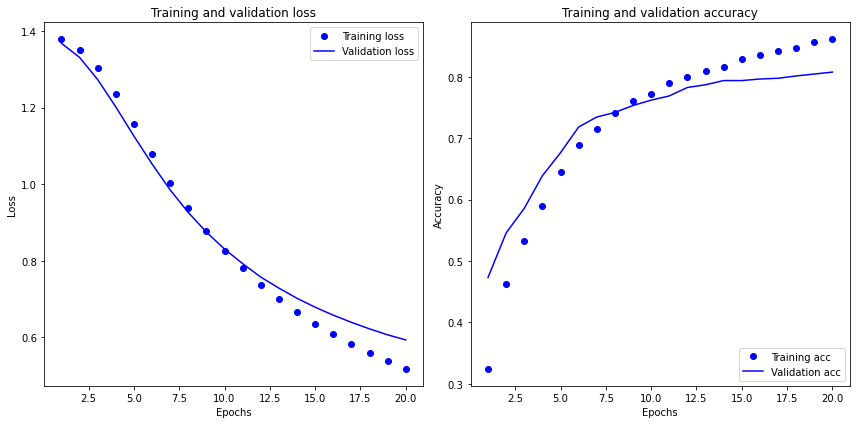

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='lower right')
fig.tight_layout()
plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a `gradient descent` optimization — it should minimize the desired quantity (loss) on every iteration.

This isn't the case for the validation loss and accuracy — they seem to peak before the training accuracy. This is an example of `overfitting`: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, we applied the `TextVectorization` layer to the dataset before feeding text to the model. If we want to make our model capable of processing raw strings (for example, to simplify deploying it), we can include the `TextVectorization` layer inside your model. To do so, **we can create a new model using the weights we just trained**.

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss = losses.sparse_categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy']
)

### Test it with `raw_test_ds`, which yields raw strings

In [31]:
metrics = export_model.evaluate(raw_test_ds, return_dict = True)
print(metrics)

250/250 [==============================] - 6s 21ms/step - loss: 1.0684 - accuracy: 0.7831
{'loss': 1.0683928728103638, 'accuracy': 0.7831250429153442}


### Inference on new data
To get predictions for new examples, we simply call `model.predict()`.

In [32]:
text1 = """blank constructor with optional parameters i have a simple question about constructors in blank. 
will these two code snippets behave the same way?..code snippet #1:..public class foo.{.    public foo(string a = null, string b = null).    
{.      // do testing on parameters.    }.}...code snippet #2:..public class foo.{.    public foo().    {.    }..    public foo(string a).    
{.    }..    public foo(string a, string b).    {.    }.}...edit:.and if i add this to the code snippet #1? it may look a really bad idea, 
but i'm working on refactoring a legacy code, so i'm afraid if i do sth that will cause damage to other piece of that uses that 
class...public class foo.{.    public foo(string a = null, string b = null).    {.       if (a == null &amp;&amp; b == null).            
{.                // do sth.            }else if (a != null &amp;&amp; b == null).            {.                // do sth.            }.            
if (a != null &amp;&amp; b != null).            {.                // do sth.            }.            else.            {..            }.    }.}
"""

text2 = """add version to @@webservice i'm using blankx.jws.webservice to create my webservice, in addition to targetnamespace i would like 
to include a ""version"" attribute to mark the version of my service. what other tag can i use in addition to this one to accomplish this so 
my wdsl will look like:..&lt;schema targetnamespace=""http://example.com/2009/02/15/webservice"" version=""1.1"" 
xmlns=""http://www.w3.org/2000/10/xmlschema&gt;...i.e. it has a version attribute
"""

text3 = """incrementing a for loop by decimal value i'm trying to implement a for loop that increments by 0.1. i have one that seems to work just 
fine for an increment of 0.5. although this may be a 'false positive' since the one for 0.1 gives me some strange values for i?   
..function thisisi() {.    var x = 1;..    for (var i = (x+0.1); i &lt; 2; i += 0.1) {.        console.log('i', i);.    }..};
...seems to yield:..i 1.1.i 1.2000000000000002.i 1.3000000000000003.i 1.4000000000000004.i 1.5000000000000004.i 1.6000000000000005.i 
1.7000000000000006.i 1.8000000000000007.i 1.9000000000000008...instead of what i need which is 1.1, 1.2, 1.3 etc. ..
can someone please point out the root of my idiocy?
"""

text4 = """sharing util modules between actively developed apps we have a growing library of apps depending on a set of common util modules.  
we'd like to:...share the same utils codebase between all projects.allow utils to be extended (and fixed!) by developers working on any 
project.have this be reasonably simple to use for devs (i.e. not a big disruption to workflow).cross-platform (no diffs for devs on macs/win/linux)...
we currently do this ""manually"", with the utils versioned as part of each app.  this has its benefits, but is also quite painful to repeatedly 
fix bugs across a growing number of codebases.  ..on the plus side, it's very simple to deal with in terms of workflow - 
util module is part of each app, so on that side there is zero overhead...we also considered (fleetingly) using filesystem links or some such 
(not portable between os's)..i understand the implications about release testing and breakage, etc.  
these are less of a problem than the mismatched utils are at the moment.
"""

In [33]:
examples = tf.constant([text1, text2, text3, text4])

export_model.predict(examples)

1/1 [==============================] - 0s 483ms/step


array([[0.33762306, 0.28414628, 0.18960886, 0.18862182],
       [0.29179063, 0.22702749, 0.23004135, 0.2511405 ],
       [0.2027341 , 0.20323397, 0.3836082 , 0.21042372],
       [0.2075827 , 0.20381863, 0.20161967, 0.38697895]], dtype=float32)

In [34]:
import numpy as np
tag_labels = ['csharp', 'jave', 'javascript', 'python']
i = 0
for probs in export_model.predict(examples):
    i += 1
    print(f'The tag in text{i} is {tag_labels[np.argmax(probs)]}')

1/1 [==============================] - 0s 90ms/step
The tag in text1 is csharp
The tag in text2 is csharp
The tag in text3 is javascript
The tag in text4 is python


### Important
By including the text preprocessing logic inside your model enables us to export a model for production that simplifies **deployment**, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply our TextVectorization layer. Using it **outside** of our model enables us to do *asynchronous CPU processing and buffering* of our data when training on GPU. So, if we're training our model on the GPU, we probably want to go with this option (outside) to get the best performance while developing our model, then switch to including the TextVectorization layer inside our model when we're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.